In [1]:
!pip install kaggle
!pip install tensorflow opencv-python matplotlib scikit-learn

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from google.colab import files
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [3]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json


In [4]:
!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals
!unzip -q animal-image-dataset-90-different-animals.zip

Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals
License(s): other
animal-image-dataset-90-different-animals.zip: Skipping, found more recently modified local copy (use --force to force download)
replace animals/animals/bear/039b2ae790.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
!rm -rf /content/animals/.ipynb_checkpoints

In [6]:
import os
import shutil

dataset_path = '/content/animals/animals'
selected_classes = [
    'cat', 'dog', 'horse', 'cow', 'sheep', 'goat', 'elephant', 'deer',
    'monkey', 'camel', 'donkey', 'parrot', 'hamster', 'turtle', 'rabbit',
    'duck', 'panda', 'kangaroo', 'lion', 'bear', 'zebra', 'fish',
    'squirrel', 'leopard', 'peacock', 'chicken', 'fox'
]

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path) and folder not in selected_classes:
        shutil.rmtree(folder_path)

In [7]:
img_size = (224, 224)
batch_size = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

class_names = dataset.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))

Found 1260 files belonging to 21 classes.
Classes: ['bear', 'cat', 'cow', 'deer', 'dog', 'donkey', 'duck', 'elephant', 'fox', 'goat', 'hamster', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'parrot', 'sheep', 'squirrel', 'turtle', 'zebra']
Number of classes: 21


In [8]:
train_size = 0.8
val_size = 0.1
total = tf.data.experimental.cardinality(dataset).numpy()

train_ds = dataset.take(int(train_size * total))
val_ds = dataset.skip(int(train_size * total)).take(int(val_size * total))
test_ds = dataset.skip(int(train_size * total + val_size * total))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15, \
    callbacks=[early_stop]
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2440 - loss: 2.6916 - val_accuracy: 0.7734 - val_loss: 1.2774
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5929 - loss: 1.4792 - val_accuracy: 0.7891 - val_loss: 0.7370
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6990 - loss: 1.0169 - val_accuracy: 0.8672 - val_loss: 0.4649
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7606 - loss: 0.8053 - val_accuracy: 0.8750 - val_loss: 0.3797
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8313 - loss: 0.6147 - val_accuracy: 0.9141 - val_loss: 0.3596
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8344 - loss: 0.5572 - val_accuracy: 0.9141 - val_loss: 0.2807
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8303 - loss: 0.5161 - val_accuracy: 0.9453 - val_loss: 0.2543
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8655 - loss: 0.4755 - val_accuracy: 0.9531 - val_loss:

In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9633 - loss: 0.1225
Test Accuracy: 0.96


In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_index]
    confidence = 100 * np.max(predictions[0])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.show()

Saving ssssss.jpeg to ssssss (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


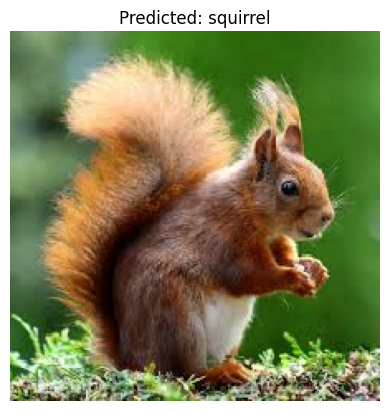

In [50]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

In [53]:
model.save('animal_classifier_model.h5')

In [52]:
from google.colab import files
files.download('animal_classifier_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>